In [ ]:
#!/usr/bin/env python2
#Inspire du fichier train_fcn8.py

import os


import argparse
import time
from getpass import getuser
from distutils.dir_util import copy_tree
import pickle

import numpy as np
import random
import theano
import theano.tensor as T
from theano import config
import lasagne
from lasagne.regularization import regularize_network_params
from lasagne.objectives import categorical_crossentropy

import PIL.Image as Image
from matplotlib import pyplot as plt
from matplotlib import colors
from matplotlib import gridspec

from fcn_1D_general import buildFCN_1D
from metrics import jaccard, accuracy, crossentropy
from data_loader.cortical_layers import CorticalLayersDataset
from simple_model import build_simple_model
from profile_functions import profile2indices 

#Stuff for profiling functions 
#os.environ['CUDA_LAUNCH_BLOCKING']='1'
#theano.config.profile= True
##theano.config.profile_memory=True
#theano.config.profile_optimizer = True

%matplotlib inline

In [ ]:
_FLOATX = config.floatX

SAVEPATH = '/Tmp/larocste/cortical_layers'
LOADPATH = '/data/lisatmp4/larocste/cortical_layers'
WEIGHTS_PATH = LOADPATH

## Hyperparameters

### Model hyperparameters
- n_filters : int, nb of filters for each convLayer
- filter_size : list of odd int (to fit with the pad='same'), len(filter_size) = nb of convLayer in simple_model, each of these layer with the corresponding filter_size
- depth : int, depth of the network (how many stacked convolution)

### Training loop parameters
- weight_decay : not implemented yet
- num_epochs : int, max number of epochs
- max_patience : int, max nb of epochs without improvement in the jaccard accuracy (jacc_valid) on the validation set
- learning rate : defined later as a theano shared variable

### Hyperparameters for the dataset loader
- batch_size=[training_batch_size, valid_batch_size, test_batch_size]
- smooth_or_raw : 'smooth' or 'raw', whether to use smooth OR raw data 
- shuffle_at_each_epoch : boolean (keep it to True)
- minibatches_subset : int, if>0 : get only that number of minibatch instead of all training dataset. 


In [3]:
#Model hyperparameters
n_filters = 64
filter_size = [7,15,25,49]  
depth  = 4
data_augmentation={} #{'horizontal_flip': True, 'fill_mode':'constant'}

#Training loop hyperparameters
weight_decay=0.001
num_epochs=500
max_patience=25
resume=False
learning_rate_value = 0.0005 #learning rate is defined below as a theano variable.



#Hyperparameters for the dataset loader
batch_size=[500,500,1]
smooth_or_raw = 'both'
shuffle_at_each_epoch = True
minibatches_subset = 0




In [4]:
#
# Prepare load/save directories
#

savepath=SAVEPATH
loadpath=LOADPATH

exp_name = 'simple_model'
exp_name += '_lrate=' + str(learning_rate_value)
exp_name += '_fil=' + str(n_filters)
exp_name += '_fsizes=' + str(filter_size)
exp_name += '_depth=' + str(depth)
exp_name += '_data=' + smooth_or_raw
exp_name += '_decay=' + str(weight_decay)
exp_name += '_pat=' + str(max_patience)
exp_name += ('_noshuffle'+str(minibatches_subset)+'batch') if not shuffle_at_each_epoch else ''
#exp_name += 'test'

dataset = 'cortical_layers'
savepath = os.path.join(savepath, dataset, exp_name)
loadpath = os.path.join(loadpath, dataset, exp_name)
print 'Savepath : ' 
print savepath
print 'Loadpath : '
print loadpath

if not os.path.exists(savepath):
    os.makedirs(savepath)
else:
    print('\033[93m The following folder already exists {}. '
          'It will be overwritten in a few seconds...\033[0m'.format(
              savepath))

print('Saving directory : ' + savepath)
with open(os.path.join(savepath, "config.txt"), "w") as f:
    for key, value in locals().items():
        f.write('{} = {}\n'.format(key, value))


Savepath : 
/Tmp/larocste/cortical_layers/cortical_layers/simple_model_lrate=0.0005_fil=64_fsizes=[7, 15, 25, 49]_depth=4_data=both_decay=0.001_pat=25
Loadpath : 
/data/lisatmp4/larocste/cortical_layers/cortical_layers/simple_model_lrate=0.0005_fil=64_fsizes=[7, 15, 25, 49]_depth=4_data=both_decay=0.001_pat=25
 The following folder already exists /Tmp/larocste/cortical_layers/cortical_layers/simple_model_lrate=0.0005_fil=64_fsizes=[7, 15, 25, 49]_depth=4_data=both_decay=0.001_pat=25. It will be overwritten in a few seconds...
Saving directory : /Tmp/larocste/cortical_layers/cortical_layers/simple_model_lrate=0.0005_fil=64_fsizes=[7, 15, 25, 49]_depth=4_data=both_decay=0.001_pat=25


In [5]:
#
# Define symbolic variables
#
input_var = T.tensor3('input_var') #n_example*nb_in_channels*ray_size
target_var = T.ivector('target_var') #n_example*ray_size

learn_step=  theano.shared(np.array(learning_rate_value, dtype=theano.config.floatX))


In [6]:
#
# Build dataset iterator
#

if smooth_or_raw =='both':
    nb_in_channels = 2
    use_threads = False
else:
    nb_in_channels = 1
    use_threads = True

train_iter = CorticalLayersDataset(
    which_set='train',
    smooth_or_raw = smooth_or_raw,
    batch_size=batch_size[0],
    data_augm_kwargs=data_augmentation,
    shuffle_at_each_epoch = shuffle_at_each_epoch,
    return_one_hot=False,
    return_01c=False,
    return_list=False,
    use_threads=use_threads)

val_iter = CorticalLayersDataset(
    which_set='valid',
    smooth_or_raw = smooth_or_raw,
    batch_size=batch_size[1],
    shuffle_at_each_epoch = shuffle_at_each_epoch,
    return_one_hot=False,
    return_01c=False,
    return_list=False,
    use_threads=use_threads)

test_iter = None



n_batches_train = train_iter.nbatches
n_batches_val = val_iter.nbatches
n_batches_test = test_iter.nbatches if test_iter is not None else 0
n_classes = train_iter.non_void_nclasses
void_labels = train_iter.void_labels


#nb_in_channels = train_iter.data_shape[0]

In [7]:
#
# Build network
#
simple_net_output, net = build_simple_model(input_var,
                    filter_size = filter_size,
                    n_filters = n_filters,
                    depth = depth,
                    nb_in_channels = nb_in_channels,
                    n_classes = n_classes)

#simple_net_output = last layer of the simple_model net
#net = dictionary containing the names of every layer (used to visualize data)

# To print each layer, uncomment this:
# lays = lasagne.layers.get_all_layers(simple_net_output)
# for l in lays:
#     print l, l.output_shape
#     #print  simple_net_output[l], simple_net_output[l].output_shape, l
# print '---------------------------'
# print 'simple_net_output :', simple_net_output
# print '---------------------------'
# #print 'net :', net

In [8]:
#
# Define and compile theano functions
#
print "Defining and compiling training functions"

prediction = lasagne.layers.get_output(simple_net_output[0])
loss = categorical_crossentropy(prediction, target_var)
loss = loss.mean()

if weight_decay > 0:
    weightsl2 = regularize_network_params(
        simple_net_output, lasagne.regularization.l2)
    loss += weight_decay * weightsl2

train_acc, train_sample_acc = accuracy(prediction, target_var, void_labels)

params = lasagne.layers.get_all_params(simple_net_output, trainable=True)
updates = lasagne.updates.adam(loss, params, learning_rate=learn_step)

train_fn = theano.function([input_var, target_var], [loss, train_acc, train_sample_acc], 
                           updates=updates)#, profile=True)

print "Done"


Defining and compiling training functions
Done


In [9]:
print "Defining and compiling valid functions"
valid_prediction = lasagne.layers.get_output(simple_net_output[0],
                                            deterministic=True)
valid_loss = categorical_crossentropy(valid_prediction, target_var)
valid_loss = valid_loss.mean()
#valid_loss = crossentropy(valid_prediction, target_var, void_labels)
valid_acc, valid_sample_acc = accuracy(valid_prediction, target_var, void_labels)
valid_jacc = jaccard(valid_prediction, target_var, n_classes)

valid_fn = theano.function([input_var, target_var], 
                           [valid_loss, valid_acc, valid_sample_acc, valid_jacc])#,profile=True)
print "Done"

Defining and compiling valid functions
Done


In [10]:
#Function computing the prediction with current parameters (for visualization)
pred = theano.function([input_var], lasagne.layers.get_output(net['probs_reshape'],
                                            deterministic=True))

In [11]:
#To visualize the ray 
def make_2Darray(arr, height = 25):
    arr = np.reshape(arr, (1,arr.shape[0]))
    x = np.repeat(arr, height, 0)
    return x


In [12]:
def plot_true_predicted_labels(X_batch, L_batch, idx_batch, smooth_or_raw='raw', index = -1, which_set=''):
    #Get random sample
    if index != -1:
        idx = index
    else:
        idx = random.randint(0,X_batch.shape[0]-1)
    
    real_idx = idx_batch[idx]

    ray = X_batch[idx][0]
    true_labels = L_batch[idx*200:(idx+1)*200]
    predicted_labels = np.argmax(pred(X_batch), axis=2)[idx]

    true_vs_predicted = np.concatenate((make_2Darray(true_labels),
                                        make_2Darray(predicted_labels)), axis = 0)

    
    if smooth_or_raw=='both':
        plt.title('Smooth vs raw data ' + which_set + ' idx = '+ str(real_idx))
        data = np.concatenate((make_2Darray(X_batch[idx][0]),
                                   make_2Darray(X_batch[idx][1])), axis=0)
        plt.imshow(data, cmap='gray', interpolation='none')
        plt.figure()
    else : 
        plt.title(smooth_or_raw + ' data ' + which_set + ' idx = '+ str(real_idx))
        plt.imshow(make_2Darray(X_batch[idx][0]), cmap='gray', interpolation='none')
        plt.figure()
        

    
    plt.title('Ground truth vs predicted labels '+ which_set + ' idx = '+ str(real_idx))
    plt.imshow(true_vs_predicted, interpolation='none', vmin=0, vmax=n_classes)
    plt.figure()

    plt.show()

In [13]:
def index_worse_than(sample_acc_batch,  idx_batch, treshold=0.7):
    
    worse_batch_idx = np.array([i for i in range(len(sample_acc_batch)) if sample_acc_batch[i]<treshold], dtype=int)
    if worse_batch_idx==[]:
        return []
    else :
        return idx_batch[worse_batch_idx]
    
    

In [14]:
# Uncomment this if only 1 minibatch (smaller dataset)
# and comment 2 lines in training loop to avoid getting new minibatches

# X_train_batch, L_train_batch = train_iter.next()
# X_val_batch, L_val_batch = val_iter.next()
# minibatches_subset = 1

# print X_train_batch.shape
# print L_train_batch.shapedata


In [15]:
#whether to plot labels prediction or not during training 
#(1 random example of the last minibatch for each epoch)
plot_results_train = True #from the training set
plot_results_valid = True #from the validation set

treshold = 0.7 # for extracting the very incorrect labelled samples
ratios=[0.80,0.85, 0.90] #ratios for the per sample accuracy

Start training


/part/01/Tmp/lisa/os_v5/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:4: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.


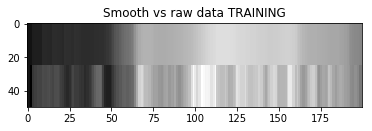

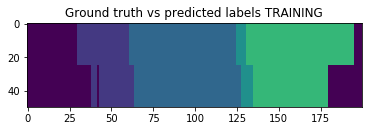

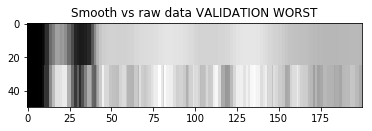

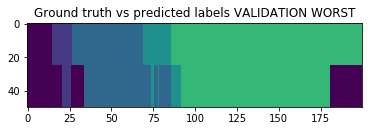

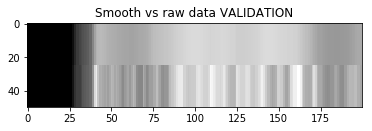

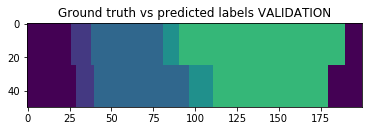

EPOCH 0: Avg cost train 2.076502, acc train 0.852381, cost val 0.368006, acc val 0.862438, jacc val 0.693985 took 260.309662 s
Per sample accuracy (ratios [0.8, 0.85, 0.9])  train [ 0.79735088  0.6445614   0.38429825] valid [ 0.81584127  0.66266667  0.40184127]


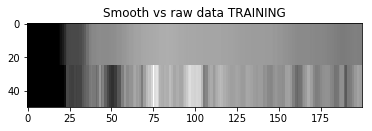

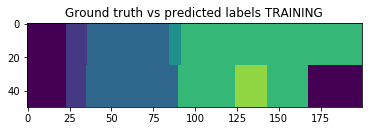

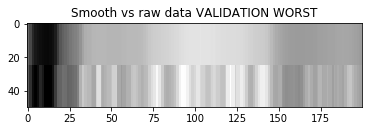

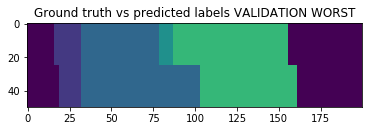

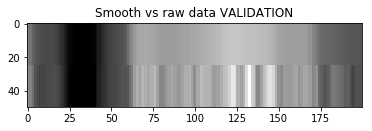

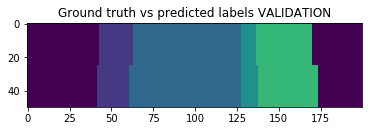

EPOCH 1: Avg cost train 1.627285, acc train 0.887325, cost val 0.290139, acc val 0.890200, jacc val 0.750712 took 260.252825 s
Per sample accuracy (ratios [0.8, 0.85, 0.9])  train [ 0.87310526  0.75968421  0.53505263] valid [ 0.88695238  0.77539683  0.53777778]
saving last model


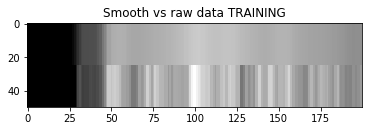

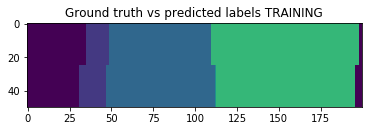

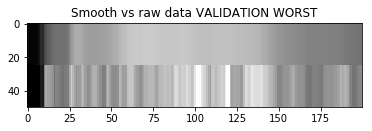

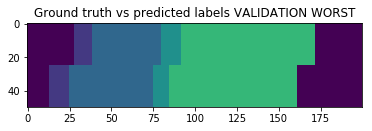

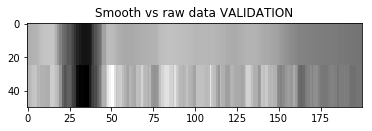

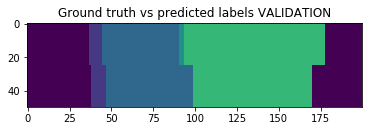

EPOCH 2: Avg cost train 1.349950, acc train 0.894847, cost val 0.272230, acc val 0.898687, jacc val 0.775196 took 260.553711 s
Per sample accuracy (ratios [0.8, 0.85, 0.9])  train [ 0.88668421  0.78698246  0.58538596] valid [ 0.89511111  0.80212698  0.61028571]
saving best (and last) model


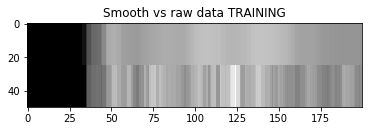

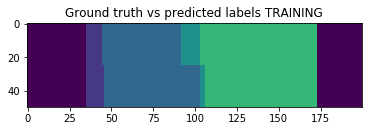

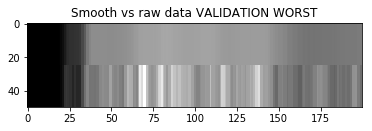

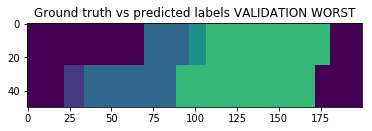

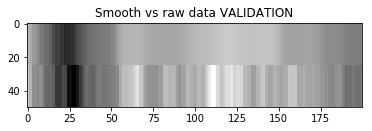

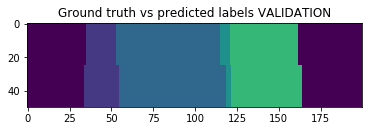

EPOCH 3: Avg cost train 1.151292, acc train 0.900980, cost val 0.269548, acc val 0.899963, jacc val 0.773498 took 260.660982 s
Per sample accuracy (ratios [0.8, 0.85, 0.9])  train [ 0.89784211  0.80814035  0.62531579] valid [ 0.89552381  0.8052381   0.61479365]
saving last model


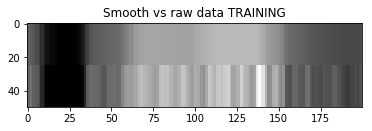

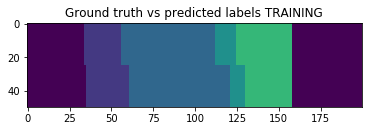

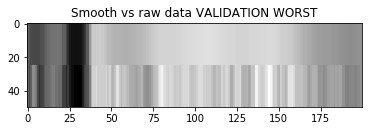

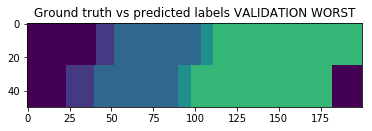

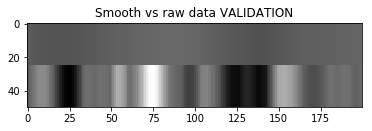

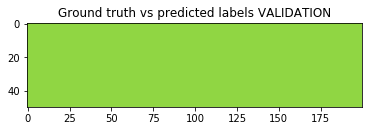

EPOCH 4: Avg cost train 1.007555, acc train 0.904402, cost val 0.275335, acc val 0.895587, jacc val 0.765161 took 261.920590 s
Per sample accuracy (ratios [0.8, 0.85, 0.9])  train [ 0.90377193  0.82178947  0.64745614] valid [ 0.88669841  0.79257143  0.59546032]
saving last model


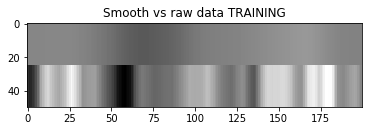

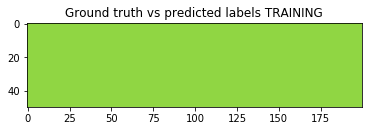

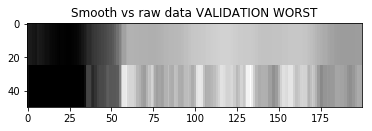

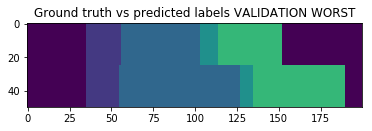

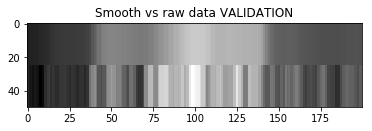

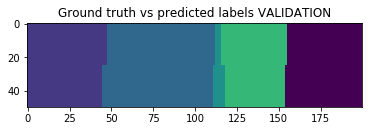

EPOCH 5: Avg cost train 0.897495, acc train 0.906353, cost val 0.316283, acc val 0.880793, jacc val 0.741025 took 260.382003 s
Per sample accuracy (ratios [0.8, 0.85, 0.9])  train [ 0.90552632  0.82622807  0.65940351] valid [ 0.8455873   0.71088889  0.48447619]
saving last model


KeyboardInterrupt: 

In [16]:
#
# Train loop
#
err_train = []
acc_train = []
sample_acc_train_tot = []
worse_indices_train = []
already_seen_idx = []

err_valid = []
acc_valid = []
jacc_valid = []
sample_acc_valid_tot = []
patience = 0
worse_indices_valid =[]



# Training main loop
print "Start training"

for epoch in range(num_epochs):
    #learn_step.set_value((learn_step.get_value()*0.99).astype(theano.config.floatX))
    
    # Single epoch training and validation
    start_time = time.time()
    #Cost train and acc train for this epoch
    cost_train_epoch = 0
    acc_train_epoch = 0
    sample_acc_train_epoch = np.array([0.0 for i in range(len(ratios))])
    worse_indices_train_epoch = []

    # Train
    if minibatches_subset > 0:
        n_batches_val = minibatches_subset
        n_batches_train = minibatches_subset
        
        
    for i in range(n_batches_train):
        # Get minibatch (comment the next line if only 1 minibatch in training)
        train_batch = train_iter.next()
        X_train_batch, L_train_batch, idx_train_batch = train_batch['data'], train_batch['labels'], train_batch['indices'][0]

        L_train_batch = np.reshape(L_train_batch, np.prod(L_train_batch.shape))
        
        # Training step
        cost_train_batch, acc_train_batch, sample_acc_train_batch = train_fn(
                                                            X_train_batch, L_train_batch)
        sample_acc_train_batch_mean = [np.mean([(i>=ratio) 
                                for i in sample_acc_train_batch]) for ratio in ratios]
        
        worse_indices_train_batch = index_worse_than(sample_acc_train_batch, 
                                          idx_train_batch, treshold=treshold)
        

        #print i, 'training batch cost : ', cost_train_batch, ' batch accuracy : ', acc_train_batch

        #Update epoch results    
        cost_train_epoch += cost_train_batch
        acc_train_epoch += acc_train_batch
        sample_acc_train_epoch += sample_acc_train_batch_mean
        worse_indices_train_epoch = np.hstack((worse_indices_train_epoch,worse_indices_train_batch))
        
    #Add epoch results    
    err_train += [cost_train_epoch/n_batches_train]
    acc_train += [acc_train_epoch/n_batches_train]
    sample_acc_train_tot += [sample_acc_train_epoch/n_batches_train]
    worse_indices_train += [worse_indices_train_epoch]
    
    if plot_results_train: #select random example from the last minibatch and plot it
        plot_true_predicted_labels(X_train_batch, L_train_batch,idx_train_batch, smooth_or_raw,which_set='TRAINING')
    

    # Validation
    cost_val_epoch = 0
    acc_val_epoch = 0
    sample_acc_valid_epoch = np.array([0.0 for i in range(len(ratios))])
    jacc_val_epoch = np.zeros((2, n_classes))
    worse_indices_val_epoch = []


    for i in range(n_batches_val):
        
        # Get minibatch (comment the next line if only 1 minibatch in training)
        val_batch = val_iter.next()
        X_val_batch, L_val_batch, idx_val_batch = val_batch['data'], val_batch['labels'], val_batch['indices'][0]

        L_val_batch = np.reshape(L_val_batch, np.prod(L_val_batch.shape))
        

        # Validation step
        cost_val_batch, acc_val_batch, sample_acc_valid_batch, jacc_val_batch = valid_fn(X_val_batch, L_val_batch)
        #print i, 'validation batch cost : ', cost_val_batch, ' batch accuracy : ', acc_val_batch
        worst_index = np.argmin(sample_acc_valid_batch)
        
        
        sample_acc_valid_batch_mean = [np.mean([(i>=ratio) 
                                for i in sample_acc_valid_batch]) for ratio in ratios]
        
        worse_indices_val_batch = index_worse_than(sample_acc_valid_batch, 
                                          idx_val_batch, treshold=treshold)
        


        #Update epoch results
        cost_val_epoch += cost_val_batch
        acc_val_epoch += acc_val_batch
        sample_acc_valid_epoch += sample_acc_valid_batch_mean
        jacc_val_epoch += jacc_val_batch
        worse_indices_val_epoch = np.hstack((worse_indices_val_epoch, worse_indices_val_batch))
        
    
    if plot_results_valid: #select random example from the last minibatch and plot it
        plot_true_predicted_labels(X_val_batch, L_val_batch, idx_val_batch, smooth_or_raw, index=worst_index, which_set='VALIDATION WORST')
        plot_true_predicted_labels(X_val_batch, L_val_batch, idx_val_batch, smooth_or_raw, which_set='VALIDATION')

    #Add epoch results 
    err_valid += [cost_val_epoch/n_batches_val]
    acc_valid += [acc_val_epoch/n_batches_val]
    sample_acc_valid_tot += [sample_acc_valid_epoch/n_batches_val]
    jacc_perclass_valid = jacc_val_epoch[0, :] / jacc_val_epoch[1, :]
    jacc_valid += [np.mean(jacc_perclass_valid)]
    worse_indices_valid += [worse_indices_val_epoch]
    

    #Print results (once per epoch)
    
    out_str = "EPOCH %i: Avg cost train %f, acc train %f"+\
        ", cost val %f, acc val %f, jacc val %f took %f s"
    out_str = out_str % (epoch, err_train[epoch],
                         acc_train[epoch],
                         err_valid[epoch],
                         acc_valid[epoch],
                         jacc_valid[epoch],
                         time.time()-start_time)
    out_str2 = 'Per sample accuracy (ratios ' + str(ratios) + ') '
    out_str2 += ' train ' +str(sample_acc_train_tot[epoch]) 
    out_str2 += ' valid ' + str(sample_acc_valid_tot[epoch])
    print out_str
    print out_str2

    

    # Early stopping and saving stuff
    
    with open(os.path.join(savepath, "fcn1D_output.log"), "a") as f:
        f.write(out_str + "\n")
        
    if epoch == 0:
        best_jacc_val = jacc_valid[epoch]
    elif epoch > 1 and jacc_valid[epoch] > best_jacc_val:
        print('saving best (and last) model')
        best_jacc_val = jacc_valid[epoch]
        patience = 0
        np.savez(os.path.join(savepath, 'new_fcn1D_model_best.npz'),
                 *lasagne.layers.get_all_param_values(simple_net_output))
        np.savez(os.path.join(savepath , "fcn1D_errors_best.npz"),
                 err_train=err_train, acc_train=acc_train,
                 err_valid=err_valid, acc_valid=acc_valid, jacc_valid=jacc_valid)
        np.savez(os.path.join(savepath, 'new_fcn1D_model_last.npz'),
                 *lasagne.layers.get_all_param_values(simple_net_output))
        np.savez(os.path.join(savepath , "fcn1D_errors_last.npz"),
                 err_train=err_train, acc_train=acc_train,
                 err_valid=err_valid, acc_valid=acc_valid, jacc_valid=jacc_valid)
    else:
        patience += 1
        print('saving last model')
        np.savez(os.path.join(savepath, 'new_fcn1D_model_last.npz'),
                 *lasagne.layers.get_all_param_values(simple_net_output))
        np.savez(os.path.join(savepath , "fcn1D_errors_last.npz"),
                 err_train=err_train, acc_train=acc_train,
                 err_valid=err_valid, acc_valid=acc_valid, jacc_valid=jacc_valid)
    # Finish training if patience has expired or max nber of epochs reached

    if patience == max_patience or epoch == num_epochs-1:
        if savepath != loadpath:
            print('Copying model and other training files to {}'.format(loadpath))
            copy_tree(savepath, loadpath)
        break 




In [20]:
worse_train = np.sort(worse_indices_train[4])
for i in worse_train:
    print int(i)

11
71
113
133
143
166
410
502
513
539
618
841
853
874
922
951
1000
1011
1020
1032
1146
1157
1167
1226
1245
1255
1277
1320
1340
1511
1533
1555
1614
1962
1967
1989
2031
2049
2256
2312
2465
2469
2474
2486
2492
2496
2517
2518
2542
2548
2562
2572
2599
2674
2692
2889
2911
2987
3098
3116
3165
3182
3223
3258
3443
3461
3466
3528
3585
3607
3739
3930
3973
4002
4013
4023
4147
4187
4227
4248
4298
4309
4323
4326
4335
4336
4354
4357
4370
4374
4424
4464
4553
4559
4570
4592
4593
4603
4675
4691
4723
4724
4725
4730
4817
5028
5036
5057
5063
5074
5101
5162
5185
5191
5193
5197
5283
5294
5303
5312
5314
5318
5323
5325
5336
5347
5356
5358
5362
5369
5372
5400
5402
5404
5406
5409
5414
5415
5417
5430
5431
5465
5472
5476
5478
5484
5488
5506
5507
5518
5556
5607
5752
5850
5861
6011
6074
6141
6163
6168
6173
6179
6263
6280
6285
6411
6416
6678
7246
7361
7397
7399
7400
7402
7403
7405
7406
7413
7502
7513
7519
7649
7737
7739
7742
7744
7747
7748
7752
7760
7801
7908
8030
8052
8184
8411
8479
8551
8581
8891
8991
9023
9034
905

In [21]:
worse_valid = np.sort(worse_indices_valid[4])
for i in worse_valid:
    print int(i)

32
859
1235
1998
3050
3366
3445
3530
3602
4344
4349
5051
5170
5329
5379
5390
5411
5441
5453
5483
5494
5519
5613
6291
7508
7751
8180
8613
8881
9066
10203
10213
10985
11042
11350
12169
12993
13376
13383
13490
14366
14390
14552
14880
15129
15327
15583
15719
15788
15792
15796
15805
15808
15809
15879
16885
16892
17045
17051
17304
18432
18543
18639
18667
18687
18931
19033
19163
19333
20125
21117
21201
21217
21219
21235
21245
21268
21277
21313
21314
21328
21342
21354
21402
21744
21751
21817
22058
22092
23476
23570
23580
23627
23632
23681
23690
23729
23875
23910
25322
25548
26524
26929
27051
27062
27383
28357
28419
28850
29127
29139
29140
29141
29150
29153
29158
29179
29240
29242
29271
29285
29292
29325
29326
29340
29351
29357
29375
29382
29397
29426
29435
29436
29441
29449
29516
29518
29521
29523
29524
29527
29550
29560
29569
29572
29613
29654
29664
29688
29705
29713
29724
29733
29737
29750
29814
29815
29816
29820
29829
29834
29856
29859
29860
29891
29901
29906
29944
30092
30929
31081
31202
3

In [22]:

#####################################################################################
# Stuff for computational graphs and profiling functions (to analyse theano behavior)
#####################################################################################

# with open('/u/larocste/cortical_layers/train_fct_debugprint_stephanie.txt', 'w') as save_file:
#     theano.printing.debugprint(train_fn, file=save_file)

# train_fn.profile.summary()

# with open('/u/larocste/cortical_layers/test_fct_debugprint_stephanie.txt', 'w') as save_file:
#     theano.printing.debugprint(valid_fn, file=save_file)

# valid_fn.profile.summary()



In [23]:
def show_feature_maps(net, layers_name, subset=25, type = 'grayscale'):
    #Show feature maps for the net's layers_name in grayscale or regular plot
    #(example below)
    
    p = lasagne.layers.get_all_param_values(net[layers_name])
    nb = min(subset, p[0].shape[0])
    if type =='grayscale':
        for i in range(subset):
            plt.imshow(make_2Darray(p[0][i, 0, :], height = 5), cmap='gray')
            plt.figure()
    elif type =='regular':
        for i in range(subset):
            plt.plot(p[0][i, 0, :])
            plt.show()
        

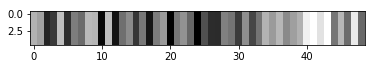

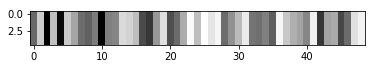

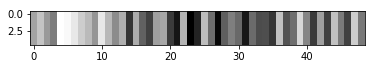

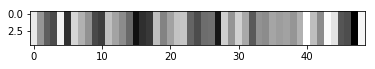

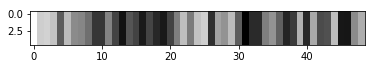

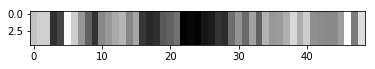

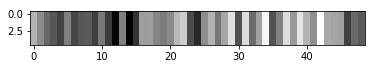

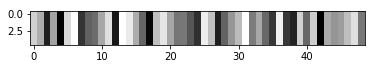

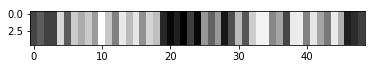

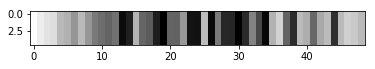

In [24]:
show_feature_maps(net, layers_name = 'relu3_3',subset=10, type='grayscale')

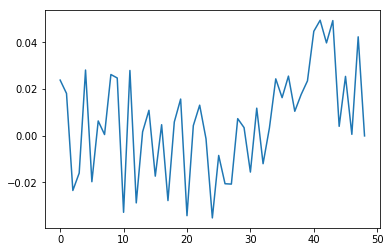

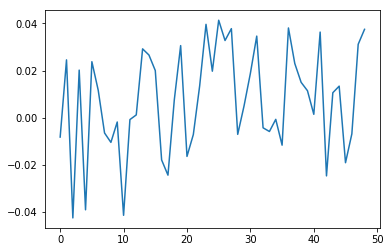

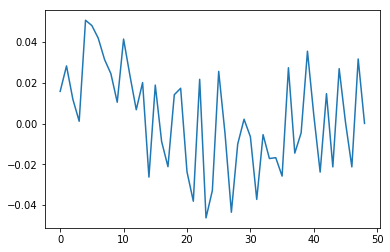

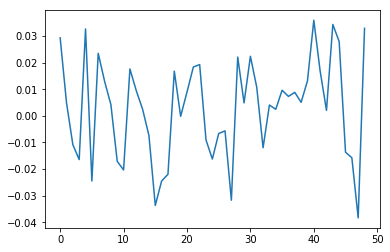

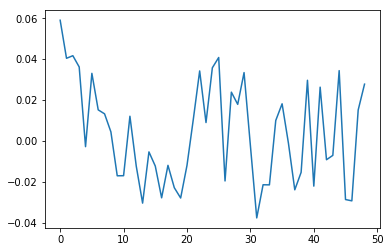

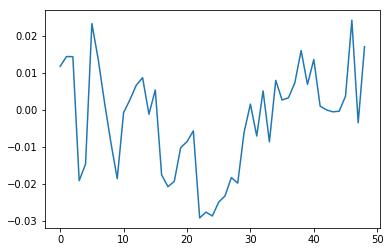

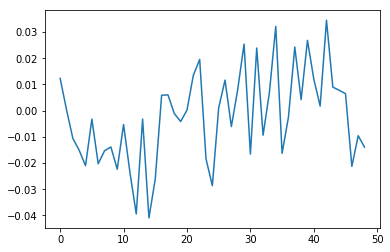

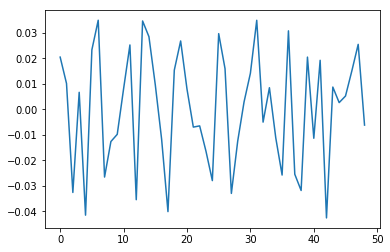

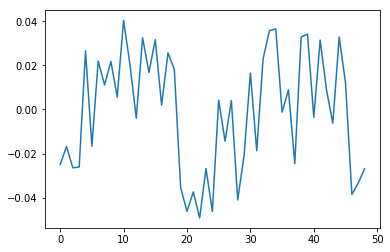

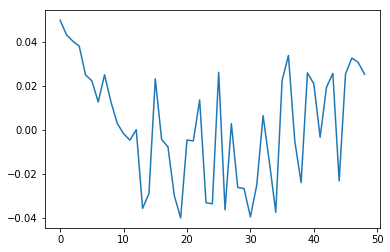

In [25]:
show_feature_maps(net, 'relu3_3',subset =10, type='regular')

In [26]:
def plot_error_acc_curves(err_train = err_train, err_valid = err_valid,
                    acc_train = acc_train, acc_valid=acc_valid, jacc_valid =jacc_valid):
    plt.title('Cost error')
    plt.plot(err_train, 'blue', label='cost train')
    plt.plot(err_valid, 'orange', label='cost valid')
    #plt.ylim((0,2))
    plt.legend()
    plt.figure()
    
    plt.title('Accuracy')
    plt.plot(acc_train, 'blue', label='acc train')
    plt.plot(acc_valid, 'orange', label='acc valid')
    plt.plot(jacc_valid, 'green', label='jaccard valid')
    plt.legend()
    
    
    
    

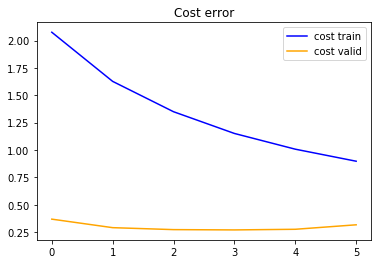

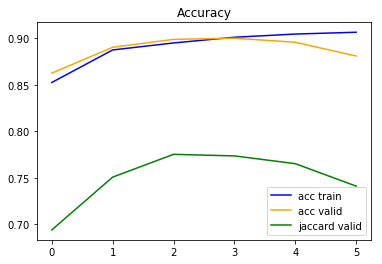

In [27]:
plot_error_acc_curves()

## Ground truth labels colors :

- Purple : label 0 (padding)
- Purple/blue : label 1 (layers 1)
- blue : label 2 (layer 2-3)
- turkoise : label 3 (layers 4 ... almost never present in the predicted labels)
- green : label 4 (layer 5-6)
- yellow : label 5 (nonsense)

### Thoughts after version 2

- Batch normalization (BN) helped a lot with the accuracy. 25% to 80% accuracy by adding BN to each convlayer
- Label 3 seems really hard to predict. Often predicted as label 4 
    - true labels distribution (per class) [4607, 1539, 5637, 976, 6041, 1200]
    - pred labels distribution (per class) [4980, 1470, 6702, 0, 6188, 660]
- Can't learn (yet) the nonsense label
- Learning rate 0.005 seems too big --lot of fluctuations in the cost error (0.001 seems fine, maybe lower could be good too)

### Thoughts after version 3

- Can now achieve 93-95% training accuracy, 90-91% validation accuracy
- Can now predict class 3 and nonsense labels (better than in version 2)

- Per sample accuracy as early stopping criterion? 
- Use raw+smooth? (instead of just raw)
- Try to simplify the model (simpler the better)

### Thoughts after version 4

- Using raw+smooth (i.e. 2 in_channels) requires use_threads=False. If set to True, each epoch takes ~500sec instead of ~300sec. Back to ~300sec when set to False. When only 1 in_channel, what is faster? (Does it change something).

## Best hyper-parameters so far

- n_filters = 64
- filter_size = [7, 15, 25, 49]
- depth = 4
- weight_decay = 0.001
- num epochs max = 500
- max patience = 25
- learning rate initial value = 0.0005
- smooth or raw ? raw
- batch size = [500, 500, 1]
- shuffle at each epoch ? True n_subset = 0


### Achieves

- Training cost : 0.22
- Validation cost : 0.23

- Training accuracy (per pixel) : 94.1%
- Validation accuracy (per pixel) : 91.4%
- Validation jaccard accuracy : 80.6%

## Better hyperparameters have been found (in terms of % of the sample that achives >90%)